In [1]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/jun/PersonReID')
# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import scipy.io
import yaml
import math
from tqdm import tqdm
from model import * 
from utils.utils import fuse_all_conv_bn
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image  

# Options
# --------

parser = argparse.ArgumentParser(description='Test')
parser.add_argument('--gpu_ids',default='0', type=str,help='gpu_ids: e.g. 0  0,1,2  0,2')
parser.add_argument('--which_epoch',default='last', type=str, help='0,1,2,3...or last')
parser.add_argument('--data_dir',default='/home/jun/ReID_Dataset/duke/dataloader',type=str, help='./test_data')
parser.add_argument('--name', default='ft_ResNet50', type=str, help='save model path')
parser.add_argument('--batchsize', default=256, type=int, help='batchsize')
parser.add_argument('--linear_num', default=512, type=int, help='feature dimension: 512 or default or 0 (linear=False)')
parser.add_argument('--use_dense', action='store_true', help='use densenet121' )
parser.add_argument('--use_efficient', action='store_true', help='use efficient-b4' )
parser.add_argument('--use_hr', action='store_true', help='use hr18 net' )
parser.add_argument('--cuhk03', action='store_true', help='use PCB' )
parser.add_argument('--PCB', action='store_true', help='use PCB' )
parser.add_argument('--use_latrans', action='store_true', help='use LA_Transformer' )
parser.add_argument('--use_vit', action='store_true', help='use Vision Transformer (ViT)' )
parser.add_argument('--multi', action='store_true', help='use multiple query' )
parser.add_argument('--fp16', action='store_true', help='use fp16.' )
parser.add_argument('--ibn', action='store_true', help='use ibn.' )
parser.add_argument('--ms',default='1', type=str,help='multiple_scale: e.g. 1 1,1.1  1,1.1,1.2')

opt = parser.parse_args(['--name','SwinV1_all_trick_duke', '--which_epoch', 'last'])
###load config###
# load the training config
config_path = os.path.join('../model',opt.name,'opts.yaml')
with open(config_path, 'r') as stream:
        config = yaml.load(stream, Loader=yaml.FullLoader) # for the new pyyaml via 'conda install pyyaml'
opt.arcface = config['arcface']
opt.circle = config['circle']
opt.cosface = config['cosface']
opt.contrast = config['contrast']
opt.instance = config['instance']
opt.triplet = config['triplet']
opt.lifted = config['lifted']
opt.sphere = config['sphere']
if 'centroid' in config:      
    opt.centroid = config['centroid']        
else:
    opt.centroid = False
opt.fp16 = config['fp16'] 
opt.PCB = config['PCB']
opt.use_dense = config['use_dense']
opt.use_NAS = config['use_NAS']
opt.stride = config['stride']
if 'use_swin' in config:
    opt.use_swin = config['use_swin']
else:
    opt.use_swin = False 
if 'use_swinv2' in config:
    opt.use_swinv2 = config['use_swinv2']
else:
    opt.use_swinv2 = False
if 'use_convnext' in config:
    opt.use_convnext = config['use_convnext']
else:
    opt.use_convnext = False
if 'use_efficient' in config:
    opt.use_efficient = config['use_efficient']
else:
    opt.use_efficient = False
if 'use_hr' in config:
    opt.use_hr = config['use_hr']
else:
    opt.use_hr = False
if 'use_vit' in config:
    opt.use_vit = config['use_vit']
else:
    opt.use_vit = False
if 'use_vitraw' in config:
    opt.use_vitraw = config['use_vitraw']
else:
    opt.use_vitraw = False
if 'use_latrans' in config:
    opt.use_latrans = config['use_latrans']
else:
    opt.use_latrans = False
if 'use_latransv2' in config:
    opt.use_latransv2 = config['use_latransv2']
else:
    opt.use_latransv2 = False
if 'use_laswin' in config:
    opt.use_laswin = config['use_laswin']
else:
    opt.use_laswin = False
    
if 'use_caswin' in config:
    opt.use_caswin = config['use_caswin']
else:
    opt.use_caswin = False
    
if 'use_laswinv2' in config:
    opt.use_laswinv2 = config['use_laswinv2']
else:
    opt.use_laswinv2 = False
if 'O2LS' in config:
    opt.O2LS = config['O2LS']
else:
    opt.O2LS = False    
if 'PCB' in config:
    opt.PCB = config['PCB']
else:
    opt.PCB = False
if 'nclasses' in config: # tp compatible with old config files
    opt.nclasses = config['nclasses']
else: 
    opt.nclasses = 751 
if 'ibn' in config:
    opt.ibn = config['ibn']
if 'linear_num' in config:
    opt.linear_num = config['linear_num']
str_ids = opt.gpu_ids.split(',')
#which_epoch = opt.which_epoch
name = opt.name
if 'data_dir' in config:
    opt.data_dir = config['data_dir']

opt.data_dir = '/home/jun/ReID_Dataset/duke/dataloader'
data_dir = opt.data_dir
if 'cuhk03' in config:
    opt.cuhk03 = config['cuhk03']
opt.droprate = config['droprate']
gpu_ids = []
for str_id in str_ids:
    id = int(str_id)
    if id >=0:
        gpu_ids.append(id)

print('We use the scale: %s'%opt.ms)
str_ms = opt.ms.split(',')
ms = []
for s in str_ms:
    s_f = float(s)
    ms.append(math.sqrt(s_f))

# set gpu ids
if len(gpu_ids)>0:
    torch.cuda.set_device(gpu_ids[0])
    cudnn.benchmark = True

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
if opt.use_swin or opt.use_vit:
    h, w = 224, 224
else:
    h, w = 256, 128
h, w = 224, 224
transform_train_list = [
        #transforms.RandomResizedCrop(size=128, scale=(0.75,1.0), ratio=(0.75,1.3333), interpolation=3), #Image.BICUBIC)
        transforms.Resize((h, w), interpolation=3),
        transforms.ToTensor(),
        ]

transform_val_list = [
        transforms.Resize(size=(h, w),interpolation=3), #Image.BICUBIC
        transforms.ToTensor(),
        ]
data_transforms = {
    'train': transforms.Compose( transform_train_list ),
    'val': transforms.Compose(transform_val_list),
}
normalize = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

if opt.PCB:
    transform_train_list = [
        transforms.Resize((384,192), interpolation=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        ]
    transform_val_list = [
        transforms.Resize(size=(384,192),interpolation=3), #Image.BICUBIC
        transforms.ToTensor()
        ]

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'train_val/val'),
                                          data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=opt.batchsize,
                                             shuffle=True, num_workers=2, pin_memory=True,
                                             prefetch_factor=2, persistent_workers=True) # 8 workers may work faster
              for x in ['train', 'val']}
class_names = image_datasets['val'].classes
use_gpu = torch.cuda.is_available()

######################################################################
# Load model
#---------------------------
def load_network(network):
    save_path = os.path.join('../model',name,'net_%s.pth'%opt.which_epoch)
    network.load_state_dict(torch.load(save_path))
    return network


We use the scale: 1


In [2]:
######################################################################
# Load Collected data Trained model
print('-------test-----------')
return_feature = opt.arcface or opt.cosface or opt.circle or opt.triplet or opt.contrast or opt.instance or opt.lifted or opt.sphere or opt.centroid
if opt.use_dense:
    model_structure = ft_net_dense(opt.nclasses, stride = opt.stride, linear_num=opt.linear_num)
elif opt.use_NAS:
    model_structure = ft_net_NAS(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_swin:
    model_structure = ft_net_swin(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_swinv2:
    model_structure = ft_net_swinv2(opt.nclasses, (h,w),  linear_num=opt.linear_num)
elif opt.use_convnext:
    model_structure = ft_net_convnext(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_efficient:
    model_structure = ft_net_efficient(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_hr:
    model_structure = ft_net_hr(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_latrans:
    lmbd = 8
    model_structure = LATransformer(opt.nclasses, linear_num=256)
elif opt.use_vit:
    model_structure = ViTReID(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_laswin:
    model_structure = LASwinV2(opt.nclasses, opt.droprate, opt.stride, circle = False, linear_num=opt.linear_num, vertical=True)
elif opt.use_laswinv2:
    model_structure = LASwin(opt.nclasses, opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num, vertical=False)
elif opt.use_caswin:
    model_structure = CASwin(opt.nclasses, opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num)
elif opt.O2LS:
    model_structure = O2LSwin(opt.nclasses, opt.droprate, opt.stride, linear_num=opt.linear_num)
else:
    model_structure = ft_net(opt.nclasses, stride = opt.stride, ibn = opt.ibn, linear_num=opt.linear_num)
if opt.PCB:
    model_structure = PCB(opt.nclasses)

#if opt.fp16:
#    model_structure = network_to_half(model_structure)

model = load_network(model_structure).cuda()

-------test-----------


/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ft_net_swin (ft_net_swin)                               [32, 3, 224, 224]    [32, 702]            --                   True
├─SwinTransformer (model)                               --                   --                   --                   True
│    └─PatchEmbed (patch_embed)                         [32, 3, 224, 224]    [32, 56, 56, 128]    --                   True
│    │    └─Conv2d (proj)                               [32, 3, 224, 224]    [32, 128, 56, 56]    6,272                True
│    │    └─LayerNorm (norm)                            [32, 56, 56, 128]    [32, 56, 56, 128]    256                  True
│    └─Sequential (layers)                              [32, 56, 56, 128]    [32, 7, 7, 1024]     --                   True
│    │    └─SwinTransformerStage (0)                    [32, 56, 56, 128]    [32, 56, 56, 128]    397,896              True
│  

In [4]:
model

ft_net_swin(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bi

In [5]:
start = 0
limits = 5
image_results = {}
class image_result():
    def __init__(self, rgb_img):
        self.data = {'Original':rgb_img}
        
    def add_element(self, model_name, img):
        self.data.update({model_name: img})
resize = transforms.Resize((256, 128), interpolation=3)
for i, (rgb_img, label) in enumerate(image_datasets['train']):
    if i >= start and i < limits+start:
        
        input_tensor = normalize(rgb_img).unsqueeze(0).cuda()
        rgb_img = np.float32(rgb_img.permute(1,2,0))
        rgb_img_reshaped = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)
        image_results[i] = image_result(rgb_img_reshaped)
        for block_id in range(6):
            if block_id == 0:
                target_layers = [model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=112, width=112):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif block_id == 1:
                target_layers = [model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=56, width=56):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif block_id == 2:
                target_layers = [model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=28, width=28):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            else:
                target_layers = [model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result 
            #reshape_transform(input_tensor)
            cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
            targets = [(ClassifierOutputTarget(label))]
            
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                eigen_smooth=True,
                                aug_smooth=True)
            
            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]

            
            visualization = resize(torch.from_numpy(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)).permute(2,0,1)).permute(1,2,0)
            image_results[i].add_element(f'Block [{block_id}]', visualization)
            #print(visualization.shape)
            #rgb_img = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AttributeError: 'ft_net_swin' object has no attribute 'layers'

In [6]:
start = 0
limits = 5
image_results = {}
class image_result():
    def __init__(self, rgb_img):
        self.data = {'Original':rgb_img}
        
    def add_element(self, model_name, img):
        self.data.update({model_name: img})
resize = transforms.Resize((256, 128), interpolation=3)
for i, (rgb_img, label) in enumerate(image_datasets['train']):
    if i >= start and i < limits+start:
        
        input_tensor = normalize(rgb_img).unsqueeze(0).cuda()
        rgb_img = np.float32(rgb_img.permute(1,2,0))
        rgb_img_reshaped = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)
        image_results[i] = image_result(rgb_img_reshaped)
        for block_id in range(5):
            if block_id == 0:
                target_layers = [model.model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=112, width=112):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif block_id == 1:
                target_layers = [model.model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=56, width=56):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif block_id == 2:
                target_layers = [model.model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=28, width=28):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif block_id == 3:
                target_layers = [model.model.layers[block_id].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result 
            else:
                target_layers = [model.model.norm]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result 
            #reshape_transform(input_tensor)
            cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
            targets = [(ClassifierOutputTarget(label))]
            
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                eigen_smooth=True,
                                aug_smooth=True)
            
            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]

            
            visualization = resize(torch.from_numpy(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)).permute(2,0,1)).permute(1,2,0)
            image_results[i].add_element(f'Block [{block_id}]', visualization)
            #print(visualization.shape)
            #rgb_img = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


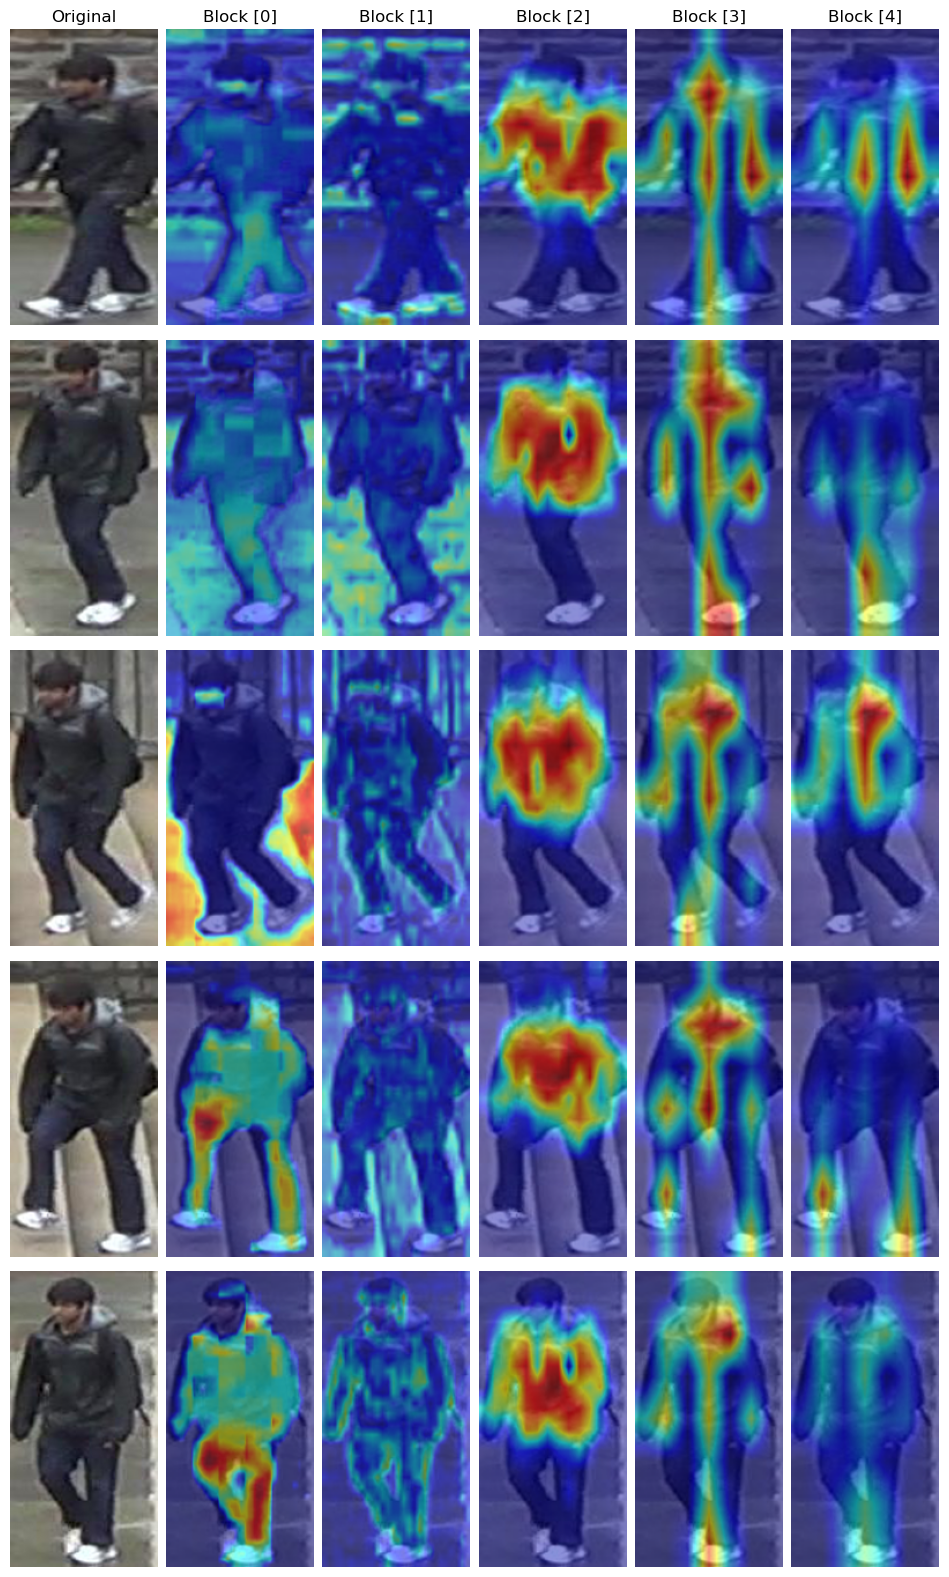

In [ ]:
ncols = len(image_results[next(iter(image_results))].data)
nrows = len(image_results[next(iter(image_results))].data.items())
fig = plt.figure(figsize=(2*ncols, 4*nrows))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for col, (img_id, image_data) in enumerate(image_results.items()):
    for row, (model_name, data) in enumerate(image_data.data.items()):
        position = (col * nrows) + row + 1
        img = data
        ax = plt.subplot(ncols, nrows, position)
        #print(img.shape)
        ax.imshow(img)
        if col==0:
            ax.set_title(f'{model_name}',fontsize = 12)
        ax.axis(False)